In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from time import gmtime, strftime

# Data Generation
np.random.seed(1024)

# Data Generation Parameter
exp1_dim = 20
exp1_no_clients = 20                                                      ### Number of nodes

exp1_m = [100] * exp1_no_clients                                          ### List of number of functions per each node

exp1_L = 1
exp1_mu = 0.01



exp1_M = []
exp1_M_client = []
exp1_z = []
exp1_z_client = []

exp1_A_client = []
exp1_B_client = []
exp1_C_client = []
exp1_mu_client = []
exp1_lipschitz_client = []
exp1_l_cocoercive_function = []
exp1_l_cocoercive_client = []

for client_idx in range(exp1_no_clients):
    M = []
    z = []
    
    A_client_m = []
    B_client_m = []
    C_client_m = []
    
    for _ in range(exp1_m[client_idx]):
        
        evalues = np.random.uniform(exp1_mu, exp1_L, exp1_dim)
        rndm_mx = np.random.normal(0, 1, (exp1_dim, exp1_dim))
        q, Q = np.linalg.eig(rndm_mx.T @ rndm_mx)    
        A = Q @ np.diag(evalues) @ Q.T
        A_client_m.append(A)
    
        evalues = np.random.uniform(exp1_mu, exp1_L, exp1_dim)
        rndm_mx = np.random.normal(0, 1, (exp1_dim, exp1_dim))
        q, Q = np.linalg.eig(rndm_mx.T @ rndm_mx)    
        C = Q @ np.diag(evalues) @ Q.T
        C_client_m.append(C)
        
        evalues = np.random.uniform(0, exp1_L, exp1_dim)
        rndm_mx = np.random.normal(0, 1, (exp1_dim, exp1_dim))
        q, Q = np.linalg.eig(rndm_mx.T @ rndm_mx)  
        B = Q @ np.diag(evalues) @ Q.T
        B_client_m.append(B)
        
        M.append(np.block([[A, B], [-B, C]]))
        z.append(np.concatenate((np.random.normal(0, 1, exp1_dim), np.random.normal(0, 1, exp1_dim))))
        exp1_eval_function = np.linalg.eig(M[-1])[0]
        exp1_l_cocoercive_function.append(1/np.min(np.real(1/ exp1_eval_function[np.abs(exp1_eval_function) > 1e-5])))
    
    exp1_A_client.append(np.mean(A_client_m, axis = 0))    ### Mean of A present in each client
    exp1_B_client.append(np.mean(B_client_m, axis = 0))    ### Mean of B present in each client
    exp1_C_client.append(np.mean(C_client_m, axis = 0))    ### Mean of C present in each client 
    exp1_M_client.append(np.mean(M, axis = 0))
    exp1_z_client.append(np.mean(z, axis = 0))
    
    exp1_mu_client.append(np.min((np.linalg.eig(exp1_A_client[-1])[0], np.linalg.eig(exp1_C_client[-1])[0])))  ### List of \mu for each client
    exp1_lipschitz_client.append(np.sqrt(max(np.linalg.eig(np.mean(M, axis = 0).T @ np.mean(M, axis = 0))[0])))
    exp1_eval_client = np.linalg.eig(exp1_M_client[-1])[0]
    exp1_l_cocoercive_client.append(1/np.min(np.real(1/ exp1_eval_client[np.abs(exp1_eval_client) > 1e-5])))
    
    exp1_M.append(M)
    exp1_z.append(z)
    
exp1_M_mean = np.mean(exp1_M_client, axis = 0)
exp1_z_mean = np.mean(exp1_z_client, axis = 0)


exp1_x_optimal = -np.linalg.inv(exp1_M_mean) @ exp1_z_mean
exp1_lipschitz_total = np.sqrt(np.max(np.linalg.eig(exp1_M_mean.T @ exp1_M_mean)[0]))


def exp1_operator(x, client_idx = None, m_idx = None):
    if client_idx == None and m_idx == None:
        return exp1_M_mean @ x + exp1_z_mean
    elif m_idx == None:
        return exp1_M_client[client_idx] @ x + exp1_z_client[client_idx]
    else:
        return exp1_M[client_idx][m_idx] @ x + exp1_z[client_idx][m_idx]

In [2]:
def ProxSkip_VIP_FL(x_initial, x_optimal, no_client, m, gamma, prob, operator, communication_round = 1000):
    ### no_clients = the number of nodes
    ### m = list of size no_clients containing the number of functions available to each client 
    ### gamma = step-size
    ### prob = probability of a communication step
    
    x = x_initial
    dim = len(x_initial)
    initial_error = np.sum((x - x_optimal)**2)
    error = [1]
    
    control_variate_client = np.zeros((no_client, dim))
    x_client = np.ones((no_client, 1)) * x
    x_hat_client = np.zeros((no_client, dim))
    x_dash_client = np.zeros((no_client, dim))
    
    rounds = 0
    while rounds < (communication_round - 1):
        theta = np.random.binomial(1, p = prob)
        
        if theta == 1:
            rounds += 1
            for client_idx in range(no_client):
                g_client = operator(x_client[client_idx], client_idx)/ no_client      ### Gradients scaled by number of nodes
                x_hat_client[client_idx] = x_client[client_idx] - gamma * (g_client - control_variate_client[client_idx]) 
                x_dash_client[client_idx] = x_hat_client[client_idx] - (gamma/ prob) * control_variate_client[client_idx]
            x = np.mean(x_dash_client, axis= 0)
            x_client = np.ones((no_client, 1)) * x
            error.append(np.sum((x - x_optimal)**2)/ initial_error)
            for client_idx in range(no_client):
                control_variate_client[client_idx] = control_variate_client[client_idx] + (prob/ gamma) * (x_client[client_idx] - x_hat_client[client_idx])
        else:
            for client_idx in range(no_client):
                g_client = operator(x_client[client_idx], client_idx)/ no_client
                x_client[client_idx] = x_client[client_idx] - gamma * (g_client - control_variate_client[client_idx])
    return error






def local_GDA(x_initial, x_optimal, no_client, m, L, mu, operator, sync_gap, communication_round = 1000):
    ### no_clients = the number of nodes
    ### m = list of size no_clients containing the number of functions available to each client 
    ### mu = minimum of smoothness of functions
    
    x = x_initial
    initial_error = np.sum((x - x_optimal)**2)
    error = []
    kappa = L/mu
    a = 2048*sync_gap*(kappa**2)
    
    x_client = np.ones((no_client, 1)) * x
    
    total_iteration = 0
    for rounds in range(communication_round):
        x = np.mean(x_client, axis= 0)
        error.append(np.sum((x - x_optimal)**2)/ initial_error)
        for client_idx in range(no_client):
            x_client[client_idx] = x
            for iteration in range(sync_gap):
                total_iteration += 1
                gamma = 8/(mu * (total_iteration + a))
                x_client[client_idx] = x_client[client_idx] - gamma * operator(x_client[client_idx], client_idx)
    return error






def local_EG(x_initial, x_optimal, no_client, m, gamma1, gamma2, operator, sync_gap, communication_round = 1000):
    ### no_clients = the number of nodes
    ### m = list of size no_clients containing the number of functions available to each client 
    ### mu = minimum of smoothness of functions
    
    x = x_initial
    initial_error = np.sum((x - x_optimal)**2)
    error = []
    
    x_client = np.ones((no_client, 1)) * x
    
    for rounds in range(communication_round):
        x = np.mean(x_client, axis= 0)
        error.append(np.sum((x - x_optimal)**2)/ initial_error)
        for client_idx in range(no_client):
            x_client[client_idx] = x
            for iteration in range(sync_gap):
                x_client_mid = x_client[client_idx] - gamma1 * operator(x_client[client_idx], client_idx)
                x_client[client_idx] = x_client[client_idx] - gamma2 * operator(x_client_mid, client_idx)
    return error

In [3]:
# Experiment Parameter
exp1_communication_round = 400
exp1_sync_gap = int(exp1_communication_round/ exp1_no_clients)

ProxSkip_error = ProxSkip_VIP_FL(np.zeros(2 * exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, exp1_no_clients/(2 * np.max(exp1_l_cocoercive_client)), np.sqrt(np.min(exp1_mu_client)/ (2 * np.max(exp1_l_cocoercive_client))), exp1_operator, communication_round= exp1_communication_round)
local_GDA_error = local_GDA(np.zeros(2 * exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, np.max(exp1_lipschitz_client), np.min(exp1_mu_client), exp1_operator, int(exp1_communication_round/ exp1_no_clients), communication_round= exp1_communication_round)
local_EG_error = local_EG(np.zeros(2 * exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(21 * exp1_sync_gap * np.max(exp1_lipschitz_client)), 1/(21 * exp1_sync_gap * np.max(exp1_lipschitz_client)), exp1_operator, exp1_sync_gap, communication_round= exp1_communication_round)

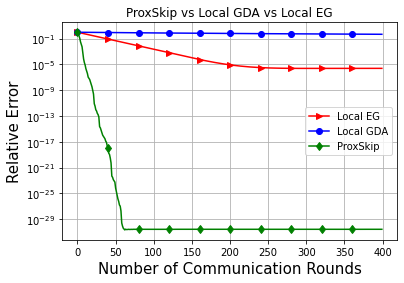

In [4]:
fig = plt.figure()
markers_on = np.arange(0, exp1_communication_round, exp1_communication_round/10).astype(int).tolist()

plt.plot(np.arange(exp1_communication_round), local_EG_error,'-r>', markevery = markers_on, label = 'Local EG')
plt.plot(np.arange(exp1_communication_round), local_GDA_error,'-bo', markevery = markers_on, label = 'Local GDA')
plt.plot(np.arange(exp1_communication_round), ProxSkip_error, '-gd', markevery = markers_on, label = 'ProxSkip')

# exp1_sync_gap = 10
# local_EG_error1 = local_EG(np.zeros(2 * exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(21 * exp1_sync_gap * np.max(exp1_lipschitz_client)), 1/(21 * exp1_sync_gap * np.max(exp1_lipschitz_client)), exp1_operator, exp1_sync_gap, communication_round= exp1_communication_round)
# plt.plot(np.arange(exp1_communication_round), local_EG_error1,'-y>', markevery = markers_on, label = 'Local EG H ='+ str(exp1_sync_gap))

# exp1_sync_gap = 20
# local_EG_error2 = local_EG(np.zeros(2 * exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(21 * exp1_sync_gap * np.max(exp1_lipschitz_client)), 1/(21 * exp1_sync_gap * np.max(exp1_lipschitz_client)), exp1_operator, exp1_sync_gap, communication_round= exp1_communication_round)
# plt.plot(np.arange(exp1_communication_round), local_EG_error2,'-m>', markevery = markers_on, label = 'Local EG H ='+ str(exp1_sync_gap))

# exp1_sync_gap = 50
# local_EG_error3 = local_EG(np.zeros(2 * exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(21 * exp1_sync_gap * np.max(exp1_lipschitz_client)), 1/(21 * exp1_sync_gap * np.max(exp1_lipschitz_client)), exp1_operator, exp1_sync_gap, communication_round= exp1_communication_round)
# plt.plot(np.arange(exp1_communication_round), local_EG_error3,'-k>', markevery = markers_on, label = 'Local EG H ='+ str(exp1_sync_gap))

plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error", fontsize = 15)
plt.xlabel("Number of Communication Rounds", fontsize = 15)
plt.legend(fontsize = 10)
plt.title("ProxSkip vs Local GDA vs Local EG")
plt.savefig('Plots/QGxDETERMINISTICxTheoretical_' + strftime("%Y%m%d-%H%M%S") + '.pdf', format='pdf', bbox_inches='tight')